In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
# 1 represents real, 0 fake
df['label'] = 1

In [5]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [6]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


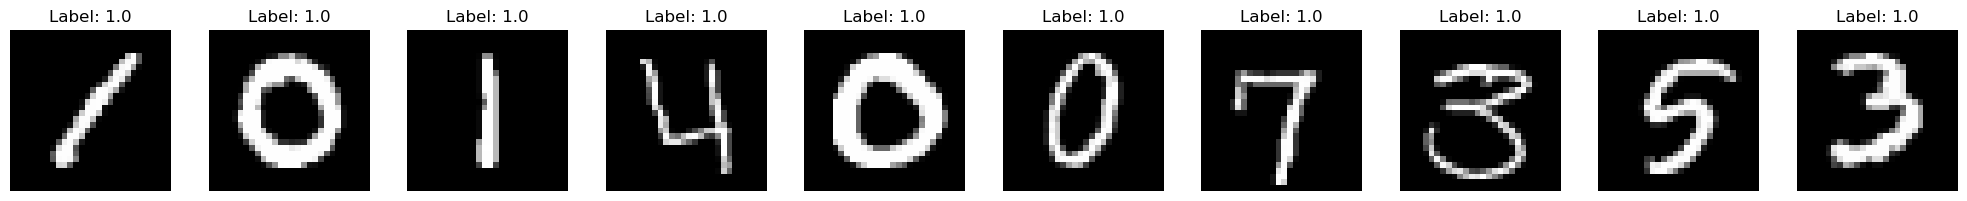

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = torch.tensor(X_discriminator).float() / 255.0

In [9]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=32, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = F.sigmoid(self.convT5(x))
        return x

In [12]:
noise_dim = 49
generator = Generator(noise_dim=noise_dim)
discriminator = Discriminator()

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

100%|████████████████████████████████████████████████████| 1313/1313 [03:53<00:00,  5.62it/s, loss_D=1.2, loss_G=0.928]


Epoch [1/30] - Average D loss: 1.1629, Average G loss: 1.0601


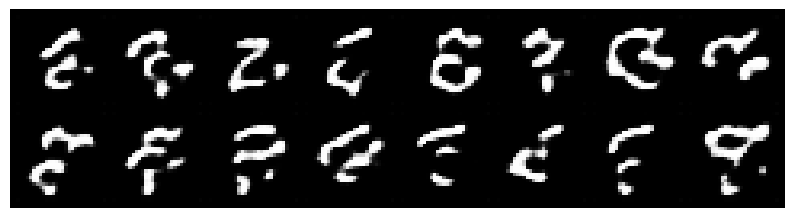

100%|███████████████████████████████████████████████████| 1313/1313 [03:38<00:00,  6.00it/s, loss_D=1.33, loss_G=0.731]


Epoch [2/30] - Average D loss: 1.2693, Average G loss: 0.8561


100%|███████████████████████████████████████████████████| 1313/1313 [03:47<00:00,  5.76it/s, loss_D=0.978, loss_G=1.25]


Epoch [3/30] - Average D loss: 1.1767, Average G loss: 0.9697


100%|███████████████████████████████████████████████████| 1313/1313 [03:40<00:00,  5.95it/s, loss_D=0.945, loss_G=1.75]


Epoch [4/30] - Average D loss: 1.0520, Average G loss: 1.1792


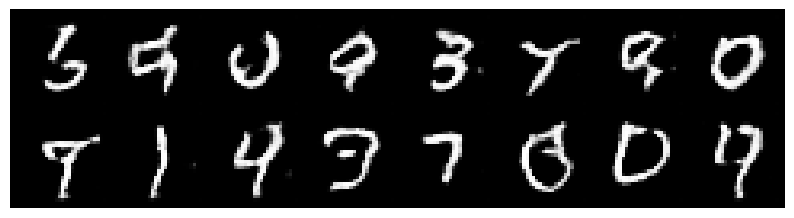

100%|███████████████████████████████████████████████████| 1313/1313 [03:38<00:00,  6.02it/s, loss_D=0.851, loss_G=1.42]


Epoch [5/30] - Average D loss: 0.9434, Average G loss: 1.3890


100%|████████████████████████████████████████████████████| 1313/1313 [03:36<00:00,  6.06it/s, loss_D=1.15, loss_G=1.23]


Epoch [6/30] - Average D loss: 0.8736, Average G loss: 1.5510


100%|███████████████████████████████████████████████████| 1313/1313 [03:37<00:00,  6.04it/s, loss_D=0.653, loss_G=1.95]


Epoch [7/30] - Average D loss: 0.8251, Average G loss: 1.6664


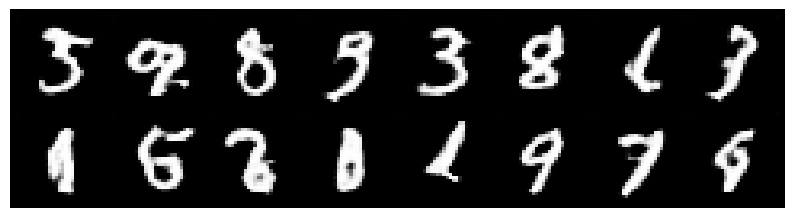

100%|███████████████████████████████████████████████████| 1313/1313 [03:38<00:00,  6.02it/s, loss_D=0.895, loss_G=2.38]


Epoch [8/30] - Average D loss: 0.7878, Average G loss: 1.7968


100%|███████████████████████████████████████████████████| 1313/1313 [03:38<00:00,  6.00it/s, loss_D=0.704, loss_G=3.97]


Epoch [9/30] - Average D loss: 0.7467, Average G loss: 1.9119


100%|███████████████████████████████████████████████████| 1313/1313 [03:39<00:00,  5.98it/s, loss_D=0.603, loss_G=2.74]


Epoch [10/30] - Average D loss: 0.7005, Average G loss: 2.0085


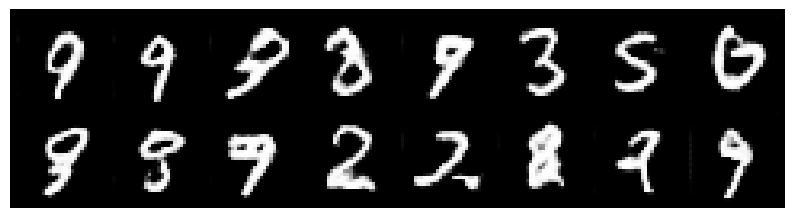

100%|███████████████████████████████████████████████████| 1313/1313 [02:38<00:00,  8.29it/s, loss_D=0.534, loss_G=1.68]


Epoch [11/30] - Average D loss: 0.6855, Average G loss: 2.0549


100%|███████████████████████████████████████████████████| 1313/1313 [02:25<00:00,  9.04it/s, loss_D=0.611, loss_G=1.56]


Epoch [12/30] - Average D loss: 0.6681, Average G loss: 2.1242


100%|███████████████████████████████████████████████████| 1313/1313 [02:26<00:00,  8.98it/s, loss_D=0.752, loss_G=1.53]

Epoch [13/30] - Average D loss: 0.6682, Average G loss: 2.1376


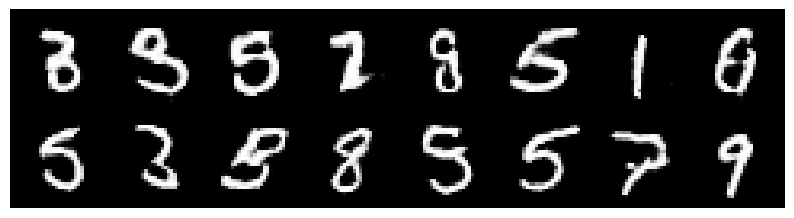

100%|████████████████████████████████████████████████████| 1313/1313 [02:28<00:00,  8.87it/s, loss_D=0.776, loss_G=1.3]


Epoch [14/30] - Average D loss: 0.6628, Average G loss: 2.1326


100%|███████████████████████████████████████████████████| 1313/1313 [02:26<00:00,  8.96it/s, loss_D=0.377, loss_G=2.04]


Epoch [15/30] - Average D loss: 0.6629, Average G loss: 2.1197


100%|███████████████████████████████████████████████████| 1313/1313 [02:26<00:00,  8.99it/s, loss_D=0.669, loss_G=1.62]


Epoch [16/30] - Average D loss: 0.6634, Average G loss: 2.0994


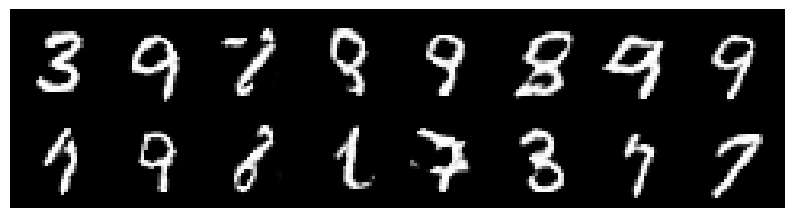

100%|███████████████████████████████████████████████████| 1313/1313 [02:25<00:00,  9.02it/s, loss_D=0.601, loss_G=2.36]


Epoch [17/30] - Average D loss: 0.6662, Average G loss: 2.0907


100%|███████████████████████████████████████████████████| 1313/1313 [02:26<00:00,  8.96it/s, loss_D=0.675, loss_G=1.89]


Epoch [18/30] - Average D loss: 0.6687, Average G loss: 2.0577


100%|███████████████████████████████████████████████████| 1313/1313 [02:18<00:00,  9.49it/s, loss_D=0.567, loss_G=2.35]

Epoch [19/30] - Average D loss: 0.6684, Average G loss: 2.0722


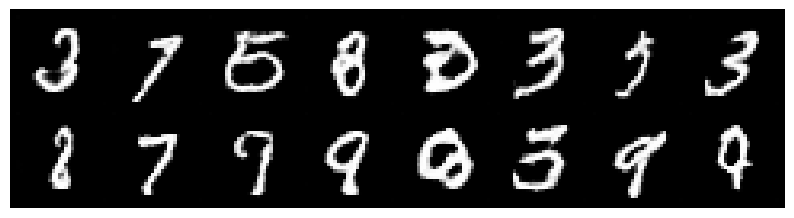

100%|███████████████████████████████████████████████████| 1313/1313 [01:48<00:00, 12.05it/s, loss_D=0.699, loss_G=2.19]


Epoch [20/30] - Average D loss: 0.6601, Average G loss: 2.0793


100%|███████████████████████████████████████████████████| 1313/1313 [01:47<00:00, 12.20it/s, loss_D=0.829, loss_G=1.84]


Epoch [21/30] - Average D loss: 0.6620, Average G loss: 2.0704


100%|███████████████████████████████████████████████████| 1313/1313 [01:47<00:00, 12.25it/s, loss_D=0.492, loss_G=2.17]

Epoch [22/30] - Average D loss: 0.6619, Average G loss: 2.0826


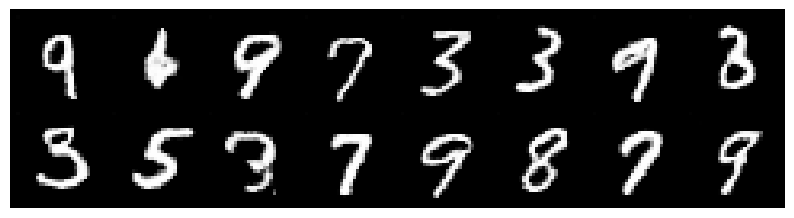

100%|███████████████████████████████████████████████████| 1313/1313 [01:46<00:00, 12.27it/s, loss_D=0.609, loss_G=2.18]


Epoch [23/30] - Average D loss: 0.6629, Average G loss: 2.0853


100%|███████████████████████████████████████████████████| 1313/1313 [01:46<00:00, 12.30it/s, loss_D=0.531, loss_G=2.45]


Epoch [24/30] - Average D loss: 0.6600, Average G loss: 2.0857


100%|███████████████████████████████████████████████████| 1313/1313 [01:47<00:00, 12.21it/s, loss_D=0.678, loss_G=1.99]

Epoch [25/30] - Average D loss: 0.6567, Average G loss: 2.0983


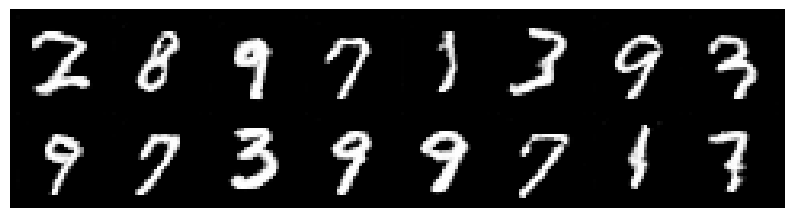

100%|███████████████████████████████████████████████████| 1313/1313 [02:11<00:00,  9.99it/s, loss_D=0.587, loss_G=1.96]


Epoch [26/30] - Average D loss: 0.6523, Average G loss: 2.1078


100%|███████████████████████████████████████████████████| 1313/1313 [03:00<00:00,  7.27it/s, loss_D=0.984, loss_G=2.11]


Epoch [27/30] - Average D loss: 0.6450, Average G loss: 2.1317


100%|██████████████████████████████████████████████████████| 1313/1313 [02:10<00:00, 10.06it/s, loss_D=0.538, loss_G=2]

Epoch [28/30] - Average D loss: 0.6431, Average G loss: 2.1290


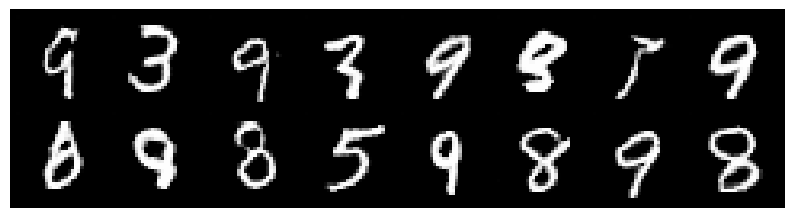

100%|███████████████████████████████████████████████████| 1313/1313 [01:54<00:00, 11.47it/s, loss_D=0.459, loss_G=2.46]


Epoch [29/30] - Average D loss: 0.6386, Average G loss: 2.1332


100%|███████████████████████████████████████████████████| 1313/1313 [02:20<00:00,  9.34it/s, loss_D=0.613, loss_G=2.24]

Epoch [30/30] - Average D loss: 0.6245, Average G loss: 2.1816


In [13]:
def preprocess_images(images):
    return images.float() * 255.0 

# Initialize variables
min_g_loss = float('inf')
epochs = 30
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)
        
        noise = torch.randn(batch_size, noise_dim)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches
    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)
        plt.figure(figsize=(10, 10))
        grid = make_grid(generated_images, nrow=8, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.show()

torch.save(generator.state_dict(), 'best_generator1.pth')

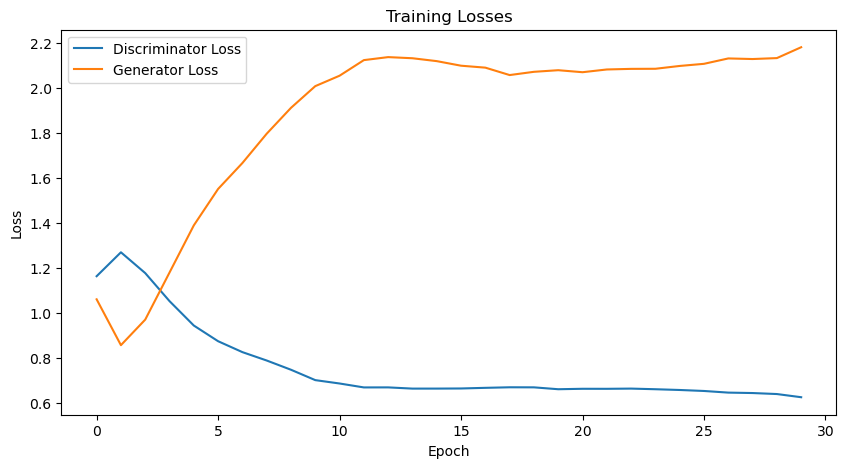

In [14]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [16]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [17]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator1.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

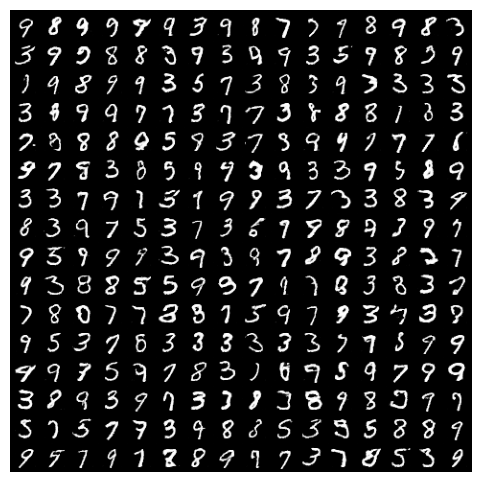

In [21]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
